In [42]:
%matplotlib inline
import pandas as pd
from mantid.simpleapi import *
import matplotlib.pyplot as plt
import numpy as np
import lmfit as lm
import h5py
import os
import json
from scipy.signal import find_peaks as fp
from datetime import datetime as dt
import pathlib
from mantid.geometry import ReflectionGenerator, ReflectionConditionFilter
from numpy.polynomial import Chebyshev as cheb
import matplotlib.gridspec as gridspec
import math as m
import scipy.stats as ss
from matplotlib.table import table
import pandas as pd
from itables import init_notebook_mode, options

#This is the location of the SummaryTxt file
SummaryTxt = r'\\isis\inst$\NDXENGINX\Instrument\logs\journal\SUMMARY.TXT'

#This is the location of the files with the Collimator Groupings
GroupingFiles = r'C:\MantidInstall\scripts\Engineering\calib'

#This is the location of the CIF files
CIF_loc = r'C:/Users/ynn46697/Documents/ISIS/Grain_Analysis/Periodic_Table_CIFs'

In [2]:
from mantid.simpleapi import *

#If there are any more groupins one may deem useful, they can create it here
def MakeGroupingFile(HorizDivs, OutputWkspName='GrpWksp', OutputFilename=None):
    CreateGroupingWorkspace(InstrumentName='ENGINX',OutputWorkspace=OutputWkspName)
    NumGroups = 10 * HorizDivs # 10 for 2*5 rows of detector modules on ENGIN-X
    PixelsInGroup = int(2400 / NumGroups)
    GroupList = []
    for GroupNo in range(1,NumGroups+1):
        GroupList = GroupList + [GroupNo] * PixelsInGroup
    for i in range(len(GroupList)):
        mtd[OutputWkspName].setY(i, [GroupList[i]])
    if OutputFilename:
        SaveDetectorsGrouping(InputWorkspace=OutputWkspName, OutputFile=OutputFilename)
        
MakeGroupingFile(24, OutputFilename=os.path.join(GroupingFiles, "ENGINX_5x24.xml"))


HDF files are a very useful and compact way to store 3D Data in a form that users can easily interact with. This cell creates the initial HDF file, as they can be very specific about naming, and after the data is filled in with other functions, a table is appended of all the parameters against all the runs. There is also a function for saving searches, peaks across banks, and orientation relations.

In [3]:
def createHDF(name):
    fn = f'{name}.hdf5'
    check = pathlib.Path(fn)
    i = 1
    while check.exists():
        new_name = f'{fn[0:-5]}({i}).hdf5'
        check = pathlib.Path(new_name)
        i += 1
    return check

def saveSearch(name, search, df):
    currdir = os.getcwd()
    savedir = os.path.join(currdir, "Saves")
    newdir = os.path.join(savedir, str(name))
    if not os.path.exists(newdir):
        os.makedirs(newdir)
    filedir = os.path.join(newdir,str(name))
    file = createHDF(filedir)
    dic = df.to_dict('list')
    with h5py.File(str(file),"w") as f:
        grp = f.create_group(search)
        for ColumnName in ['Inst','5DigitRunNumber','Users','Title','Date','Time','uAh','RB No.']:
            datset = f.create_dataset(f'{search}/{ColumnName}',data=dic[f'{ColumnName}'])
    f.close()

def storeGrpPeaks(name, df, peaklen,hkls):
#def storeGrpPeaks(name,df,peaklen):
    currdir = os.getcwd()
    savedir = os.path.join(currdir, "Saves")
    newdir = os.path.join(savedir, str(name))
    if not os.path.exists(newdir):
        os.makedirs(newdir)
    filedir = os.path.join(newdir,str(name))
    file = createHDF(filedir)
    dic = df.to_dict('list')
    #print(dic)
    with h5py.File(str(file),"w") as f:
        #for i in range(peaklen):
        for i in range(len(hkls)):
            peakPara = []
            grp = f.create_group(f'{hkls[i]}-Peak')
            for ColumnName in ['Height', 'Height_Err', 'PeakCentre', 'PeakCentre_Err', 'Sigma', 'Sigma_Err', 'Integrated Intensity', 'Integrated Intensity_Err', 'Chi_squared']:
                #datset = f.create_dataset(f'Peak No.{k}/{ColumnName}', data=dic[f'Peak No.{k}-{ColumnName}'])
                try:
                    datset = f.create_dataset(f'{hkls[i]}-Peak/{ColumnName}', data=dic[f'{hkls[i]}-{ColumnName}'])
                except KeyError:
                    print(f"Can't save {hkls[i]}-{ColumnName} into HDF. This may be due to an error with the Peak Detection.")
                    pass
    f.close()
    try:
        appendTable(file)
    except IndexError:
        pass

def saveOrientation(name,corr,table,peaklen,orderDic,peaks):
    currdir = os.getcwd()
    savedir = os.path.join(currdir, "Saves")
    newdir = os.path.join(savedir, str(name))
    if not os.path.exists(newdir):
        os.makedirs(newdir)
    filedir = os.path.join(newdir,f'{name}_Orientation_{corr}_Correlation')
    file = createHDF(filedir)
    with h5py.File(str(file),"w") as f:
        grp = f.create_group(f'{name}-Correlations')
        i = 0
        for peak in peaks:
            #grp = f.create_group(f'Peak No.{k}')
            peakCorr = []
            for j in range(peaklen):
                peakCorr.append(table[i,j])
            #print(peakCorr)
            datset = f.create_dataset(f'{name}-Correlations/{peak}', data=peakCorr)
            i = i + 1
        tableset = f.create_dataset(f'{name}-Correlations/Full Table', shape=(peaklen,peaklen), maxshape=(None,None), data=table)
    f.close()
    orderedPeaksHDF(file,orderDic,peaks)

def appendTable(filename):
    with h5py.File(filename, "r") as f:
        keyList = list(f.keys())
        #print(keyList)
        rows = len(keyList)
        cols = 0
        for i in range(rows):
            check = f[keyList[i]]
            #print(check)
            if keyList[i] == "Tables":
                i = i + 1
            else:
                checkList = list(check)
                params = len(checkList)
                colTest = len(list(check[checkList[0]]))
                #colTest = len(list(check["Inst"]))
                if colTest > cols:
                    cols = colTest
                else:
                    cols = cols
    f.close()
    with h5py.File(filename, "a") as f:
        for k in range(params):
            path = "Tables/" + checkList[k]
            tableData = f.create_dataset(path, (rows,cols), maxshape=(None,None), dtype='float')
            for i in range(rows):
                run = f[keyList[i]]
                dat = list(run[checkList[k]])
                diff = cols - len(dat)
                for j in range(diff):
                    dat.append(0)
                tableData[i,:] = dat
            
    f.close()

#This is to create a HDF of the ordered peaks
def orderedPeaksHDF(filename, orderDic,peaks):
    with h5py.File(filename,"a") as f:
        for peak in peaks:
            path = f'Ordered_Peaks/{peak}_ordered'
            arr = orderDic[f'{peak}_ordered']
            datset = f.create_dataset(path, data=arr)
    f.close()

This cell was written prior to my time with ENGIN-X, accessing a summary.txt file that logs every experiment on the instrument. It takes the txt file, seperating the columns into sections of a pandas datafile. This datafile can then be searched in order to find runs that contain certain information in the title, were performed by specific users, happened at a specific time of day, occured on a certain date or year but, due to issues with the type and the nature of datafiles, cannot search RB No. and Run Numbers.


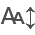

Inst  5DigitRunNumber          Users                    Title  \
RunNumber                                                                 
358141     ENG            58141                   Quiet_counts_06_02_25   
358142     ENG            58142                   Quiet_counts_06_02_25   
358143     ENG            58143                   Quiet_counts_11_02_25   
358144     ENG            58144            Lee           Xscan;X=-8.703   
358145     ENG            58145            Lee           Xscan;X=-8.203   
...        ...              ...            ...                      ...   
365835     ENG            65835  Francis,Zhang                     AW_H   
365836     ENG            65836  Francis,Zhang                     AW_H   
365837     ENG            65837  Francis,Zhang                     AW_H   
365838     ENG            65838  Francis,Zhang                     AW_H   
365839     ENG            65839  Francis,Zhang  Quiet counts, SMP veto,   

                  Date      Time      uAh   RB No.  
RunNumber                                           
358141     06-FEB-2025  11:48:21      0.0        0  
358142     06-FEB-2025  11:49:55  13026.3        0  
358143     11-FEB-2025  14:51:07   2557.8        0  
358144     17-FEB-2025  15:16:13      0.1        0  
358145     17-FEB-2025  15:54:34      0.1        0  
...                ...       ...      ...      ...  
365835     06-JUN-2025  07:12:48     44.0  2500036  
365836     06-JUN-2025  07:46:34     21.0  2500036  
365837     06-JUN-2025  08:02:58     21.0  2500036  
365838     06-JUN-2025  08:19:23     14.1  2500036  
365839     24-JUN-2025  18:19:05      0.0  2500036  

[7605 rows x 8 columns]

In [44]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

def LoadSummaryTxt(Filename,col,search,sort):
    col_names = ['Inst','5DigitRunNumber','Users','Title','Date','Time','uAh','RB No.']
    col_width = [(0,3),(3,8),(8,28),(28,52),(52,63),(63,72),(72,80),(80,88)]
    # Run 53079 on Engin-X has corrupted row
    InvalidRows = [24493,41604,41605,41606,41607,41608]
    datas = pd.read_fwf(Filename, names=col_names, colspecs=col_width, na_filter=False,  encoding='ANSI', skiprows=InvalidRows) # encoding='ISO-8859-1'
    df = pd.DataFrame(datas)
    RunNumberDiff = df['5DigitRunNumber'].diff()
    RunNumberDiff = RunNumberDiff.replace(-99999, 1).replace(-99998, 2) # Replace wraparound values
    RunNumberDiff.iloc[0] = df['5DigitRunNumber'].iloc[0]
    df['RunNumber'] = RunNumberDiff.cumsum().astype('int64')
    df['uAh'] = pd.to_numeric(df['uAh'], errors='coerce')
    df.set_index('RunNumber', inplace=True)
    try:
        searchResults = df[df[str(col)].str.contains(str(search))].sort_values(str(sort))
    except AttributeError:
        searchResults = df[str(col)].dtype
    searchQuery = f'{col}-{search}'
    hdfName = f'{search}_sort_by_{sort}'
    return searchResults

df = LoadSummaryTxt(SummaryTxt,"Date","2025","RunNumber")
df

ENGIN-X has been running experiments for about 23 years, as of writing this, and a lot in computational abilities and norms have changed over the time. This file searching function takes this into account, going through the isis servers and finding the year and relevant file format for the data requested using the run and the experiment alone. It also allows the user to determine which bank they want the data to be read from - Bank 1, Bank 2, or both.

In [5]:
def fileSearch(run,exp,bank,save=False,local=False,path=None):
    if local == True:
        dire,temp,sumSpec = localFileSearch(path=f'{path}',run=run,exp=exp,bank=bank,save=save)
        return dire,temp,sumSpec
    else:
        pass
    exps = ['Cryo','Furnace','Pressure','X Scan','Y Scan','Z Scan']
    currdir = os.getcwd() #This finds the folder that the script is being ran in
    savedir = os.path.join(currdir,'Saves') #This creates a new folder to save the data in
    newdir = os.path.join(savedir,'Runs')
    if not os.path.exists(newdir):
        os.makedirs(newdir)
    filedir = os.path.join(newdir,f'{run}')
    
    if len(str(run)) < 5:
        zero_diff = 5 - len(str(run))
        for i in range(zero_diff):
            run = f'0{run}' #This is for significantly early runs, such as 00001 and 00035 from 2002
            
    yr = dt.now().strftime('%y')
    cy = int(yr) + 1

    if bank == '1':
        sMin_One = 0
        sMax_One = 1200 #These are the spectrums to be provided to the load function. After a certain point,
        #the highest and lowest spectrum available to read are 1 and 2399 respectively, so this code factors
        #that in
        sMin_Two = 1
        sMax_Two = 1199
    elif bank == '2':
        sMin_One = 1201
        sMax_One = 2400
        sMin_Two = 1200
        sMax_Two = 2399
    elif bank == 'Both':
        sMin_One = 0
        sMax_One = 2400
        sMin_Two = 1
        sMax_Two = 2399
    else:
        sMin_One = 0
        sMax_One = 2400
        sMin_Two = 1
        sMax_Two = 2399
    for i in reversed(range(2,int(cy))):
        if i < 10:
            year = f'0{i}'
        else:
            year = f'{i}'
        if i < 17:
            #These are the names of all the parameters saved as part of the raw file or folder prior
            #to the apparent overhaul in 2017
            apps = [['cryo_1','cryo_temp1'],'furnace','position','x','y','z']
            if exp == exps[0]:
                if i < 10:
                    app = apps[0][0]
                else:
                    app = apps[0][1]
            elif exp == exps[1]:
                app = apps[1]
            elif exp == exps[2]:
                app = apps[2]
            elif exp == exps[3]:
                app = apps[3]
            elif exp == exps[4]:
                app = apps[4]
            elif exp == exps[5]:
                app = apps[5]
            elif exp == None:
                pass
            else:
                raise NameError(f'This is not included in the list of experiments. Please enter one from this list: {exps}')
        else:
            #These are the current names for the parameters found within the nexus files
            apps = ['Temp_1','Temp_3','position','X_position','Y_position','Z_position']
            if exp == exps[0]:
                app = apps[0]
            elif exp == exps[1]:
                app = apps[1]
            elif exp == exps[2]:
                app = apps[2]
            elif exp == exps[3]:
                app = apps[3]
            elif exp == exps[4]:
                app = apps[4]
            elif exp == exps[5]:
                app = apps[5]
            elif exp == None:
                pass
            else:
                raise NameError(f'This is not included in the list of experiments. Please enter one from this list: {exps}')
        for cycle in [5,4,3,2,1]:
            if i < 8:
                name_one = f'ENG{run}'
                name_two = f'ENG{run}' #This factors in a change in naming convention
            else:
                name_one = f'ENG00{run}'
                name_two = f'ENGINX00{run}'
            ext_one = '.raw'
            ext_two = '.nxs'
            #These four combinations factor in the naming convention of runs mentioned above and the filetype,
            #either nexus or raw
            testdir_one = f'//isis/inst$/NDXENGINX/Instrument/data/cycle_{year}_{cycle}/{name_one}{ext_one}'
            testdir_two = f'//isis/inst$/NDXENGINX/Instrument/data/cycle_{year}_{cycle}/{name_two}{ext_one}'
            testdir_three = f'//isis/inst$/NDXENGINX/Instrument/data/cycle_{year}_{cycle}/{name_one}{ext_two}'
            testdir_four = f'//isis/inst$/NDXENGINX/Instrument/data/cycle_{year}_{cycle}/{name_two}{ext_two}'
            check_one = pathlib.Path(testdir_one)
            check_two = pathlib.Path(testdir_two)
            check_three = pathlib.Path(testdir_three)
            check_four = pathlib.Path(testdir_four)
            if check_one.exists():
                dire = testdir_one
                name = f'ENGINX00{run}'
                dSpace = f'{name}-dSpacing'
                sumSpec = f'{name}-sumSpec'
                try:
                    Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_One, SpectrumMax=sMax_One)
                except ValueError:
                    Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_Two, SpectrumMax=sMax_Two) #For the
                    #different spectrums, mentioned earlier
                ConvertUnits(InputWorkspace=name, OutputWorkspace=dSpace, Target='dSpacing', AlignBins=True)
                SumSpectra(InputWorkspace=dSpace, OutputWorkspace=sumSpec)
                try:
                    #It searches for the parameter in the file
                    temp = mtd[sumSpec].getRun().getLogData(app).filtered_value
                except RuntimeError:
                    print(f'Unable to find {app} in file.')
                    try:
                        #If this doesn't work, it searches for the parameter in the folder
                        temp_fp = f'//isis/inst$/NDXENGINX/Instrument/data/cycle_{year}_{cycle}/{name_one}_{app}.txt'
                        temp = np.loadtxt(fname=temp_fp,dtype='float',usecols=(1))
                        if save == True:
                            try:
                                shutil.copy(temp_fp,f'{newdir}')
                            except PermissionError:
                                print('Unable to copy parameter file. May already be saved.')
                    except FileNotFoundError:
                        #If this still doesn't work, it notifies the user and carries on
                        print(f'Unable to find {app} file in folder.')
                        temp = 0
                except UnboundLocalError:
                    temp = 0
                if isinstance(temp, (np.ndarray, list)) == True:
                    try:
                        #This is due to the nature of the txt files some parameters are read from holding more
                        #information than just the parameter the user would like to retrieve
                        temp = temp[-1]
                        temp = round(temp,2)
                    except IndexError:
                        temp = temp
                        temp = round(float(temp),2)
                else:
                    temp = temp
                    temp = round(float(temp),2)
                if save == True:
                    try:
                        shutil.copy(dire,f'{newdir}')
                    except PermissionError:
                        print('Unable to copy file. May already be saved.')
                return dire, temp, sumSpec
            elif check_two.exists():
                #It then repeats this process for every potential name till it finds a fit
                dire = testdir_two
                name = f'ENGINX00{run}'
                dSpace = f'{name}-dSpacing'
                sumSpec = f'{name}-sumSpec'
                try:
                    Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_One, SpectrumMax=sMax_One)
                except ValueError:
                    Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_Two, SpectrumMax=sMax_Two)
                ConvertUnits(InputWorkspace=name, OutputWorkspace=dSpace, Target='dSpacing', AlignBins=True)
                SumSpectra(InputWorkspace=dSpace, OutputWorkspace=sumSpec)
                try:
                    temp = mtd[sumSpec].getRun().getLogData(app).filtered_value
                except RuntimeError:
                    print(f'Unable to find {app} in file.')
                    try:
                        temp_fp = f'//isis/inst$/NDXENGINX/Instrument/data/cycle_{year}_{cycle}/{name_two}_{app}.txt'
                        temp = np.loadtxt(fname=temp_fp,dtype='float',usecols=(1))
                        if save == True:
                            try:
                                shutil.copy(temp_fp,f'{newdir}')
                            except PermissionError:
                                print('Unable to copy parameter file. May already be saved.')
                    except FileNotFoundError:
                        print(f'Unable to find {app} file in folder.')
                        temp = 0
                except UnboundLocalError:
                    temp = 0
                if isinstance(temp, (np.ndarray, list)) == True:
                    try:
                        temp = temp[-1]
                        temp = round(temp,2)
                    except IndexError:
                        temp = temp
                        temp = round(float(temp),2)
                else:
                    temp = temp
                    temp = round(float(temp),2)
                if save == True:
                    try:
                        shutil.copy(dire,f'{newdir}')
                    except PermissionError:
                        print('Unable to copy file. May already be saved.')
                if check_four.exists():
                    dire = testdir_four
                return dire, temp, sumSpec
            elif check_three.exists():
                dire = testdir_three
                name = f'ENGINX00{run}'
                dSpace = f'{name}-dSpacing'
                sumSpec = f'{name}-sumSpec'
                try:
                    Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_One, SpectrumMax=sMax_One)
                except ValueError:
                    Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_Two, SpectrumMax=sMax_Two)
                ConvertUnits(InputWorkspace=name, OutputWorkspace=dSpace, Target='dSpacing', AlignBins=True)
                SumSpectra(InputWorkspace=dSpace, OutputWorkspace=sumSpec)
                try:
                    temp = mtd[sumSpec].getRun().getLogData(app).filtered_value
                except RuntimeError:
                    print(f'Unable to find {app} in file.')
                    try:
                        temp_fp = f'//isis/inst$/NDXENGINX/Instrument/data/cycle_{year}_{cycle}/{name_one}_{app}.txt'
                        temp = np.loadtxt(fname=temp_fp,dtype='float',usecols=(1))
                        if save == True:
                            try:
                                shutil.copy(temp_fp,f'{newdir}')
                            except PermissionError:
                                print('Unable to copy parameter file. May already be saved.')
                    except FileNotFoundError:
                        print(f'Unable to find {app} file in folder.')
                        temp = 0
                except UnboundLocalError:
                    temp = 0
                if isinstance(temp, (np.ndarray, list)) == True:
                    try:
                        temp = temp[-1]
                        temp = round(temp,2)
                    except IndexError:
                        temp = temp
                        temp = round(float(temp),2)
                else:
                    temp = temp
                    temp = round(float(temp),2)
                if save == True:
                    try:
                        shutil.copy(dire,f'{newdir}')
                    except PermissionError:
                        print('Unable to copy file. May already be saved.')
                return dire, temp, sumSpec
            elif check_four.exists():
                dire = testdir_four
                name = f'ENGINX00{run}'
                dSpace = f'{name}-dSpacing'
                sumSpec = f'{name}-sumSpec'
                try:
                    Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_One, SpectrumMax=sMax_One)
                except ValueError:
                    Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_Two, SpectrumMax=sMax_Two)
                ConvertUnits(InputWorkspace=name, OutputWorkspace=dSpace, Target='dSpacing', AlignBins=True)
                SumSpectra(InputWorkspace=dSpace, OutputWorkspace=sumSpec)
                try:
                    temp = mtd[sumSpec].getRun().getLogData(app).filtered_value
                except RuntimeError:
                    print(f'Unable to find {app} in file.')
                    try:
                        temp_fp = f'//isis/inst$/NDXENGINX/Instrument/data/cycle_{year}_{cycle}/{name_two}_{app}.txt'
                        temp = np.loadtxt(fname=temp_fp,dtype='float',usecols=(1))
                        if save == True:
                            try:
                                shutil.copy(temp_fp,f'{newdir}')
                            except PermissionError:
                                print('Unable to copy parameter file. May already be saved.')
                    except FileNotFoundError:
                        print(f'Unable to find {app} file in folder.')
                        temp = 0
                except UnboundLocalError:
                    temp = 0
                if isinstance(temp, (np.ndarray, list)) == True:
                    try:
                        temp = temp[-1]
                        temp = round(temp,2)
                    except IndexError:
                        temp = temp
                        temp = round(float(temp),2)
                else:
                    temp = temp
                    temp = round(float(temp),2)
                if save == True:
                    try:
                        shutil.copy(dire,f'{newdir}')
                    except PermissionError:
                        print('Unable to copy file. May already be saved.')
                return dire, temp, sumSpec
            else:
                pass

#dire,temp,sumSpec = fileSearch(346540,exp='Cryo',bank=None,save=False,local=True,path=r'C:\Users\ynn46697\Documents\ISIS\For_GitHub\Misc\Saves\Runs')
#print(dire,temp,sumSpec)

This code runs on files found in the internal servers, however, for users who are offsite or otherwise unable to connect, this function searches a given folder for the necessary raw data.

In [6]:
def localFileSearch(path,run,exp,bank,save=False):
    if run < 269853:
        app_year = False
    else:
        app_year = True
    if run < 99406:
        name_year = False
    else:
        name_year = True
    exps = ['Cryo','Furnace','Pressure','X Scan','Y Scan','Z Scan']
    currdir = os.getcwd() #This finds the folder that the script is being ran in
    savedir = os.path.join(currdir,'Saves') #This creates a new folder to save the data in
    newdir = os.path.join(savedir,'Runs')
    if not os.path.exists(newdir):
        os.makedirs(newdir)
    filedir = os.path.join(newdir,f'{run}')
    
    if len(str(run)) < 5:
        zero_diff = 5 - len(str(run))
        for i in range(zero_diff):
            run = f'0{run}' #This is for significantly early runs, such as 00001 and 00035 from 2002
            
    yr = dt.now().strftime('%y')
    cy = int(yr) + 1

    if bank == '1':
        sMin_One = 0
        sMax_One = 1200 #These are the spectrums to be provided to the load function. After a certain point,
        #the highest and lowest spectrum available to read are 1 and 2399 respectively, so this code factors
        #that in
        sMin_Two = 1
        sMax_Two = 1199
    elif bank == '2':
        sMin_One = 1201
        sMax_One = 2400
        sMin_Two = 1200
        sMax_Two = 2399
    elif bank == 'Both':
        sMin_One = 0
        sMax_One = 2400
        sMin_Two = 1
        sMax_Two = 2399
    else:
        sMin_One = 0
        sMax_One = 2400
        sMin_Two = 1
        sMax_Two = 2399
    if app_year == False:
        #These are the names of all the parameters saved as part of the raw file or folder prior
        #to the apparent overhaul in 2017
        apps = [['cryo_1','cryo_temp1'],'furnace','position','x','y','z']
        if exp == exps[0]:
            if i < 10:
                app = apps[0][0]
            else:
                app = apps[0][1]
        elif exp == exps[1]:
            app = apps[1]
        elif exp == exps[2]:
            app = apps[2]
        elif exp == exps[3]:
            app = apps[3]
        elif exp == exps[4]:
            app = apps[4]
        elif exp == exps[5]:
            app = apps[5]
        elif exp == None:
            pass
        else:
            raise NameError(f'This is not included in the list of experiments. Please enter one from this list: {exps}')
    else:
        #These are the current names for the parameters found within the nexus files
        apps = ['Temp_1','Temp_3','position','X_position','Y_position','Z_position']
        if exp == exps[0]:
            app = apps[0]
        elif exp == exps[1]:
            app = apps[1]
        elif exp == exps[2]:
            app = apps[2]
        elif exp == exps[3]:
            app = apps[3]
        elif exp == exps[4]:
            app = apps[4]
        elif exp == exps[5]:
            app = apps[5]
        elif exp == None:
            pass
        else:
            raise NameError(f'This is not included in the list of experiments. Please enter one from this list: {exps}')
    if name_year == False:
        name_one = f'ENG{run}'
        name_two = f'ENG{run}' #This factors in a change in naming convention
    else:
        name_one = f'ENG00{run}'
        name_two = f'ENGINX00{run}'
    ext_one = '.raw'
    ext_two = '.nxs'
    #These four combinations factor in the naming convention of runs mentioned above and the filetype,
    #either nexus or raw
    testdir_one = f'{path}/{name_one}{ext_one}'
    testdir_two = f'{path}/{name_two}{ext_one}'
    testdir_three = f'{path}/{name_one}{ext_two}'
    testdir_four = f'{path}/{name_two}{ext_two}'
    check_one = pathlib.Path(testdir_one)
    check_two = pathlib.Path(testdir_two)
    check_three = pathlib.Path(testdir_three)
    check_four = pathlib.Path(testdir_four)
    if check_one.exists():
        dire = testdir_one
        name = f'ENGINX00{run}'
        dSpace = f'{name}-dSpacing'
        sumSpec = f'{name}-sumSpec'
        try:
            Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_One, SpectrumMax=sMax_One)
        except ValueError:
            Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_Two, SpectrumMax=sMax_Two) #For the
            #different spectrums, mentioned earlier
        ConvertUnits(InputWorkspace=name, OutputWorkspace=dSpace, Target='dSpacing', AlignBins=True)
        SumSpectra(InputWorkspace=dSpace, OutputWorkspace=sumSpec)
        try:
            #It searches for the parameter in the file
            temp = mtd[sumSpec].getRun().getLogData(app).filtered_value
        except RuntimeError:
            print(f'Unable to find {app} in file.')
            try:
                #If this doesn't work, it searches for the parameter in the folder
                temp_fp = f'{path}/{name_one}_{app}.txt'
                temp = np.loadtxt(fname=temp_fp,dtype='float',usecols=(1))
                if save == True:
                    try:
                        shutil.copy(temp_fp,f'{newdir}')
                    except PermissionError:
                        print('Unable to copy parameter file. May already be saved.')
            except FileNotFoundError:
                #If this still doesn't work, it notifies the user and carries on
                print(f'Unable to find {app} file in folder.')
                temp = 0
        except UnboundLocalError:
            temp = 0
        if isinstance(temp, (np.ndarray, list)) == True:
            try:
                #This is due to the nature of the txt files some parameters are read from holding more
                #information than just the parameter the user would like to retrieve
                temp = temp[-1]
                temp = round(temp,2)
            except IndexError:
                temp = temp
                temp = round(float(temp),2)
        else:
            temp = temp
            temp = round(float(temp),2)
        if save == True:
            try:
                shutil.copy(dire,f'{newdir}')
            except PermissionError:
                print('Unable to copy file. May already be saved.')
        return dire, temp, sumSpec
    elif check_two.exists():
        #It then repeats this process for every potential name till it finds a fit
        dire = testdir_two
        name = f'ENGINX00{run}'
        dSpace = f'{name}-dSpacing'
        sumSpec = f'{name}-sumSpec'
        try:
            Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_One, SpectrumMax=sMax_One)
        except ValueError:
            Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_Two, SpectrumMax=sMax_Two)
        ConvertUnits(InputWorkspace=name, OutputWorkspace=dSpace, Target='dSpacing', AlignBins=True)
        SumSpectra(InputWorkspace=dSpace, OutputWorkspace=sumSpec)
        try:
            temp = mtd[sumSpec].getRun().getLogData(app).filtered_value
        except RuntimeError:
            print(f'Unable to find {app} in file.')
            try:
                temp_fp = f'{path}/{name_two}_{app}.txt'
                temp = np.loadtxt(fname=temp_fp,dtype='float',usecols=(1))
                if save == True:
                    try:
                        shutil.copy(temp_fp,f'{newdir}')
                    except PermissionError:
                        print('Unable to copy parameter file. May already be saved.')
            except FileNotFoundError:
                print(f'Unable to find {app} file in folder.')
                temp = 0
        except UnboundLocalError:
            temp = 0
        if isinstance(temp, (np.ndarray, list)) == True:
            try:
                temp = temp[-1]
                temp = round(temp,2)
            except IndexError:
                temp = temp
                temp = round(float(temp),2)
        else:
            temp = temp
            temp = round(float(temp),2)
        if save == True:
            try:
                shutil.copy(dire,f'{newdir}')
            except PermissionError:
                print('Unable to copy file. May already be saved.')
        if check_four.exists():
            dire = testdir_four
        return dire, temp, sumSpec
    elif check_three.exists():
        dire = testdir_three
        name = f'ENGINX00{run}'
        dSpace = f'{name}-dSpacing'
        sumSpec = f'{name}-sumSpec'
        try:
            Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_One, SpectrumMax=sMax_One)
        except ValueError:
            Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_Two, SpectrumMax=sMax_Two)
        ConvertUnits(InputWorkspace=name, OutputWorkspace=dSpace, Target='dSpacing', AlignBins=True)
        SumSpectra(InputWorkspace=dSpace, OutputWorkspace=sumSpec)
        try:
            temp = mtd[sumSpec].getRun().getLogData(app).filtered_value
        except RuntimeError:
            print(f'Unable to find {app} in file.')
            try:
                temp_fp = f'{path}/{name_one}_{app}.txt'
                temp = np.loadtxt(fname=temp_fp,dtype='float',usecols=(1))
                if save == True:
                    try:
                        shutil.copy(temp_fp,f'{newdir}')
                    except PermissionError:
                        print('Unable to copy parameter file. May already be saved.')
            except FileNotFoundError:
                print(f'Unable to find {app} file in folder.')
                temp = 0
        except UnboundLocalError:
            temp = 0
        if isinstance(temp, (np.ndarray, list)) == True:
            try:
                temp = temp[-1]
                temp = round(temp,2)
            except IndexError:
                temp = temp
                temp = round(float(temp),2)
        else:
            temp = temp
            temp = round(float(temp),2)
        if save == True:
            try:
                shutil.copy(dire,f'{newdir}')
            except PermissionError:
                print('Unable to copy file. May already be saved.')
        return dire, temp, sumSpec
    elif check_four.exists():
        dire = testdir_four
        name = f'ENGINX00{run}'
        dSpace = f'{name}-dSpacing'
        sumSpec = f'{name}-sumSpec'
        try:
            Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_One, SpectrumMax=sMax_One)
        except ValueError:
            Load(Filename=dire, OutputWorkspace=name, SpectrumMin=sMin_Two, SpectrumMax=sMax_Two)
        ConvertUnits(InputWorkspace=name, OutputWorkspace=dSpace, Target='dSpacing', AlignBins=True)
        SumSpectra(InputWorkspace=dSpace, OutputWorkspace=sumSpec)
        try:
            temp = mtd[sumSpec].getRun().getLogData(app).filtered_value
        except RuntimeError:
            print(f'Unable to find {app} in file.')
            try:
                temp_fp = f'{path}/{name_two}_{app}.txt'
                temp = np.loadtxt(fname=temp_fp,dtype='float',usecols=(1))
                if save == True:
                    try:
                        shutil.copy(temp_fp,f'{newdir}')
                    except PermissionError:
                        print('Unable to copy parameter file. May already be saved.')
            except FileNotFoundError:
                print(f'Unable to find {app} file in folder.')
                temp = 0
        except UnboundLocalError:
            temp = 0
        if isinstance(temp, (np.ndarray, list)) == True:
            try:
                temp = temp[-1]
                temp = round(temp,2)
            except IndexError:
                temp = temp
                temp = round(float(temp),2)
        else:
            temp = temp
            temp = round(float(temp),2)
        if save == True:
            try:
                shutil.copy(dire,f'{newdir}')
            except PermissionError:
                print('Unable to copy file. May already be saved.')
        return dire, temp, sumSpec
    else:
        pass

#dire,temp,sumSpec = localFileSearch(path=r'C:\Users\ynn46697\Documents\ISIS\For_GitHub\Misc\Saves\Runs',run=346540,exp='Cryo',bank=None)
#print(dire,temp,sumSpec)

In [7]:
#These are different runs Joe deemed useful for analysing with Grain Size
PaBrun = 324889
#Testing the code with Niobium Runs
#PaBrun = 351364
#PaBrun = 351464
#PaBrun = 351538
#PaBrun = 351637

In [8]:
#This cell contains functions needed to fit the peaks using lmfit

#This is a gaussian function which takes in heights and backgrounds as parameters in order to more closely fit to 
#neutron diffraction peaks
def gaussian_function(x, a, x0, sigma,b):
    return b+a*np.exp(-(x-x0)**2/(2*sigma**2))

#This function is part of the fitting process for lmfit, taking the initial parameters provided to the lmfit
#function and calculating the residual, repeating the process and altering the parameters to minimise the residual
def residualGauss(pars,x,data):
    model = gaussian_function(x, a=pars['a'],x0=pars['x0'],sigma=pars['sigma'],b=pars['b']) 
    return model - data

The following are functions written or brought over in order make the Log Method for finding peaks work.

In [17]:
#Find nearest and find nearest ind are both developed from this answer on stack overflow: https://stackoverflow.com/a/2566508
#It takes a value and array then tries to find the nearest element to that value in said array. find_nearest_ind then
#only returns the location of said element. This is very useful for cases where x0 values are calculated, and thus,
#may not be to the same decimal place as the approximate value in the x array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_ind(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

#This is used to log the x values of generated datasets. The x values being the d-spacing units, and the y-values
#being the intensity values
def logData(x,y):
    yNorm = y/np.amax(y) #This normalises the y values to make the correlation a lot easier
    xLog = np.log(x)
    inter = (x[-1] - x[0])/len(x)
    xSize = np.arange(xLog[0],xLog[-1],inter) #This makes sure the xLog has the same bin size as the x array. It then
    #returns said bin size so the process can be repeated for the other datasets
    xLogInterp = np.interp(xSize,x,xLog)
    yLogInterp = np.interp(xSize,xLog,yNorm)
    return xSize,yLogInterp,inter

def logInter(run,datx,bins,save,local,path,exp,bank):    
    _,temp,sumSpec = fileSearch(run,exp=exp,bank=bank,save=save,local=local,path=path)
    y = mtd[sumSpec].dataY(0)
    x = mtd[sumSpec].dataX(0)[0:len(y)] #This searches for an extracts the data before the log so it doesn't have
    #to be saved prior
    if x[0] < datx[0]:
        x_datx_ind = find_nearest_ind(x, datx[0])
        x = x[x_datx_ind:list(x).index(x[-1])] #This makes sure both the x values just extracted and the x values
        #to be compared against aren't too far off from each other, making the correlation more accurate
        y = y[x_datx_ind:len(y)]
    if len(y) < len(datx):
        #If the data is smaller than the CIF generated data, this pads the y array with zeros either side and 
        #extrapolates the x
        diff_x = int(abs(len(datx) - len(x))/2)
        diff_y = int(abs(len(datx) - len(y))/2)
        y = np.pad(y, (diff_y,diff_y), 'constant')
        x = np.pad(x, (diff_x,diff_x), 'linear_ramp',end_values=(datx[0],datx[-1]))
    if len(x) < len(y):
        #If the x is somehow still shorter it extrapolates the end, and with the y it pads with zeros afterwards
        dist = len(y) - len(x)
        inval = x[-1]/len(datx)
        x = np.pad(x, (0,dist), 'linear_ramp',end_values=(datx[0],(datx[-1]+(dist*inval))))
    if len(x) > len(y):
        dist = len(x) - len(y)
        y = np.pad(y, (0,dist), 'constant')
    #After all this, it normalises and logs like with the CIF generated dataset
    yNorm = y/np.amax(y)
    xLog = np.log(x)
    xSize = np.arange(xLog[0],xLog[-1],bins)
    xLogInterp = np.interp(xSize,x,xLog)
    yLogInterp = np.interp(xSize,xLog,yNorm)
    return x,y,xSize,yLogInterp,temp

def noise_gen(level,size):
    #This produces random noise to add to generated datasets
    noi_arr = np.random.normal(0,level,size)
    for i in range(len(noi_arr)):
        if noi_arr[i] < 0:
            noi_arr[i] = 0
    return noi_arr
    
def CIFData(element,noise_lvl,size,drange=[0.67,3.36],plot_CIF=True,CIF_loc=CIF_loc):
    #This is to create x values for the data
    x = np.linspace(drange[0],drange[1],size)
    plot = np.zeros(len(x),)
    #The bank distance and source distance are from the ENGIN-X manual in order to replicate, as much as possible,
    #realistic data
    ws = CreateSampleWorkspace(Function='Multiple Peaks',BankDistanceFromSample=0.01,SourceDistanceFromSample=50)
    LoadCIF(ws,f'{CIF_loc}/{element}.cif')
    sample = ws.sample().getCrystalStructure()
    unitCell = sample.getUnitCell()
    a = unitCell.a()
    pg = sample.getSpaceGroup().getPointGroup()
    generator = ReflectionGenerator(sample)
    hkls = list(generator.getUniqueHKLs(drange[0],drange[-1]))
    if plot_CIF == False:
        #Certain functions only need the CIF Data generation as a shortcut to determining hkls
        return hkls
    else:
        pass
    peaks = list(generator.getDValues(hkls))
    Fsq = list(generator.getFsSquared(hkls))
    j = list(map(lambda x : len(pg.getEquivalents(x)), hkls))
    s = list(map(lambda x : x*0.005, peaks))
    p = []
    fl = []
    height = []
    for i in range(len(peaks)):
        p.append((j[i]*Fsq[i]*(peaks[i]**4))/(a**3)) #This equation comes from the Introduction to 
        #the Characterization of Residual Stress by Neutron Diffraction book by M.T. Hutchings, P.J. Withers, et al.
        #with some parameters missing as these are undeterminable or negligible without a real experiment
        fl.append(flux[find_nearest_ind(flux_pt,peaks[i])])
        height.append(fl[i] * p[i])
    for peak in peaks:
        height_val = height[peaks.index(peak)]
        s_val = s[peaks.index(peak)]
        b = 0
        plot += gaussian_function(x,height_val,peak,s_val,b)
    noise = noise_gen((np.amax(plot)*noise_lvl),len(plot))
    plot = plot + noise
    return x,plot,hkls,peaks

def bg_fit(x,y,loop=25):
    #This uses chebyshev polynomials to fit to the background
    cheb_fit,_ = cheb.fit(x,y,0,full=True)
    coef = np.sum(cheb_fit.coef)
    for i in range(1,loop):
        cheb_fit,params = cheb.fit(x,y,i,full=True)
        new_coef = np.sum(cheb_fit.coef)
        coef_check = abs(0 - coef)
        new_check = abs(0 - new_coef)
        if new_check < coef_check:
            coef = new_coef
            best_fit = cheb_fit
        else:
            pass
    bg_x,bg_y = best_fit.linspace(n=len(x)) #This can be used to add a background fit to peak fits
    y_hat = abs(y - bg_y) #This can be used to remove the background from particularly noisy data
    return bg_x,bg_y,y_hat

#These three lines are necessary to allow the CIF generation to work, providing a flux calibration for it to read from
_,_,sumSpec = fileSearch(358221,exp=None,bank=None,save=False)
flux = mtd[sumSpec].dataY(0)
flux_pt = mtd[sumSpec].dataX(0)[0:len(flux)]

These are the Peak Fitting functions.

In [39]:
#This fits peaks for fcc and bcc
def cubicPeakFit(run,exp,bank,size,bg,peak_bg,save,local,path):
    paramsArr = []
    #First it generates a Vanadium and Copper sample then logs their x values
    bcc_x,bcc_y,bcc_hkls,bcc_peaks = CIFData('V',0.005,size)
    fcc_x,fcc_y,fcc_hkls,fcc_peaks = CIFData('Cu',0.005,size)
    bcc_xS,bcc_yLog,bcc_inter = logData(bcc_x,bcc_y)
    fcc_xS,fcc_yLog,fcc_inter = logData(fcc_x,fcc_y)
    #After this, it retrieves the run and logs the x values of its data too
    x,y,dat_xS,dat_yLog,temp = logInter(run,bcc_x,max(bcc_inter,fcc_inter),save,local,path,exp,bank)
    bg_x,bg_y,y_hat = bg_fit(x,y,loop=25)

    #This determines the furthest peak in the dataset
    lim = 1
    dist = 0.025
    rep = int(lim / dist)
    for i in range(rep):
        dat_end = int(len(x)*lim)
        dat_break = int(len(x)*(lim-dist))
        dat_trunx = x[dat_break:dat_end]
        dat_trunc = y[dat_break:dat_end]
        dat_peaks,dat_params = fp(dat_trunc,prominence=15,distance=100)
        lim = lim - dist
        if len(dat_peaks) > 0:
            break
    dat_peaks,_ = fp(dat_trunc)
    dat_yPeaks = list(dat_trunc[dat_peaks])
    dat_x0 = list(dat_trunx[dat_peaks])
    dat_far = np.amax(dat_yPeaks) #This is the furthest peak in y
    dat_fax = dat_x0[dat_yPeaks.index(dat_far)] #And then in x
    #The data is then correlated against both the bcc and fcc data
    corr_bcc = np.correlate(bcc_yLog,dat_yLog,mode='full')
    corr_fcc = np.correlate(fcc_yLog,dat_yLog,mode='full')
    #Then the peaks of the correlation are identified
    corr_axes = np.linspace(0,len(corr_bcc),len(corr_bcc))
    corr_bcc_peaks,corr_bcc_params = fp(corr_bcc,prominence=1)
    corr_fcc_peaks,corr_fcc_params = fp(corr_fcc,prominence=1)
    #These peaks are then collated
    bcc_x = corr_axes[corr_bcc_peaks]
    bcc_y = corr_bcc[corr_bcc_peaks]
    fcc_x = corr_axes[corr_fcc_peaks]
    fcc_y = corr_fcc[corr_fcc_peaks]
    #And sorted
    bcc_sort = sorted(bcc_y)
    fcc_sort = sorted(fcc_y)
    #Then the difference between the two highest peaks within the prominence are determined
    bcc_peak_diff = bcc_sort[-1]-bcc_sort[-2]
    fcc_peak_diff = fcc_sort[-1]-fcc_sort[-2]

    #The second peak of each crystal structure are then estimated in case the correlation failed
    a_bcc = dat_fax*np.sqrt(2)
    a_fcc = dat_fax*np.sqrt(3)
    d_two_bcc = a_bcc / 2
    d_two_fcc = a_fcc / 2
    loc_two_bcc = find_nearest_ind(x,d_two_bcc)
    loc_two_fcc = find_nearest_ind(x,d_two_fcc)
    range_two_bcc = range(loc_two_bcc-200,loc_two_bcc+200)
    range_two_fcc = range(loc_two_fcc-200,loc_two_fcc+200)
    bcc_two_peak,bcc_two_par = fp(y[range_two_bcc],prominence=15)
    fcc_two_peak,fcc_two_par = fp(y[range_two_fcc],prominence=15)
    
    if bcc_peak_diff > fcc_peak_diff:
        #This is a double check because sometimes the dataset reads as the wrong crystal structure
        if y[loc_two_fcc] > y[loc_two_bcc]:
            #This is a triple check
            if len(bcc_two_par['prominences']) == len(fcc_two_par['prominences']):
                cryst = 'fcc'
                hkls = fcc_hkls
                dVals = fcc_peaks
                a = a_fcc
            elif len(bcc_two_par['prominences']) > len(fcc_two_par['prominences']):
                cryst = 'bcc'
                hkls = bcc_hkls
                dVals = bcc_peaks
                a = a_bcc
            elif len(bcc_two_par['prominences']) < len(fcc_two_par['prominences']):
                cryst = 'fcc'
                hkls = fcc_hkls
                dVals = fcc_peaks
                a = a_fcc
            else:
                cryst = 'fcc'
                hkls = fcc_hkls
                dVals = fcc_peaks
                a = a_fcc
        else:
            if len(bcc_two_par['prominences']) == len(fcc_two_par['prominences']):
                cryst = 'fcc'
                hkls = fcc_hkls
                dVals = fcc_peaks
                a = a_fcc
            elif len(bcc_two_par['prominences']) > len(fcc_two_par['prominences']):
                cryst = 'bcc'
                hkls = bcc_hkls
                dVals = bcc_peaks
                a = a_bcc
            elif len(bcc_two_par['prominences']) < len(fcc_two_par['prominences']):
                cryst = 'fcc'
                hkls = fcc_hkls
                dVals = fcc_peaks
                a = a_fcc
            else:
                cryst = 'bcc'
                hkls = bcc_hkls
                dVals = bcc_peaks
                a = a_bcc
    else:
        if y[loc_two_bcc] > y[loc_two_fcc]:
            if len(bcc_two_par['prominences']) == len(fcc_two_par['prominences']):
                cryst = 'fcc'
                hkls = fcc_hkls
                dVals = fcc_peaks
                a = a_fcc
            elif len(bcc_two_par['prominences']) > len(fcc_two_par['prominences']):
                cryst = 'bcc'
                hkls = bcc_hkls
                dVals = bcc_peaks
                a = a_bcc
            elif len(bcc_two_par['prominences']) < len(fcc_two_par['prominences']):
                cryst = 'fcc'
                hkls = fcc_hkls
                dVals = fcc_peaks
                a = a_fcc
            else:
                cryst = 'bcc'
                hkls = bcc_hkls
                dVals = bcc_peaks
                a = a_bcc
        else:
            if len(bcc_two_par['prominences']) == len(fcc_two_par['prominences']):
                cryst = 'fcc'
                hkls = fcc_hkls
                dVals = fcc_peaks
                a = a_fcc
            elif len(bcc_two_par['prominences']) > len(fcc_two_par['prominences']):
                cryst = 'bcc'
                hkls = bcc_hkls
                dVals = bcc_peaks
                a = a_bcc
            elif len(bcc_two_par['prominences']) < len(fcc_two_par['prominences']):
                cryst = 'fcc'
                hkls = fcc_hkls
                dVals = fcc_peaks
                a = a_fcc
            else:
                cryst = 'fcc'
                hkls = fcc_hkls
                dVals = bcc_peaks
                a = a_fcc
    #This was for testing, to make sure it's reading the correct peak, crystal structure, and lattice parameter            
    check_arr = [dat_fax,cryst,a]

    if cryst == 'bcc':
        #Originally, the x0 values were calculated from the hkls values, but this would run into problems with cases
        #such as [5,1,1] and [3,3,3] peaks, where the peak would double back on itself and crash the panda datafiles
        #in Grain Size. This takes the d-spacing values from the ratio between the sample and the generated data
        #in order to get around that
        bcc_bcc = np.correlate(bcc_yLog,bcc_yLog,mode='full')
        bcc_bcc_peak = np.amax(bcc_bcc)
        diff = bcc_bcc_peak - bcc_sort[-1]
        log_diff = bcc_inter * diff
        rat = np.exp(log_diff)
    elif cryst == 'fcc':
        fcc_fcc = np.correlate(fcc_yLog,fcc_yLog,mode='full')
        fcc_fcc_peak = np.amax(fcc_fcc)
        diff = fcc_fcc_peak - fcc_sort[-1]
        log_diff = fcc_inter * diff
        rat = np.exp(log_diff)

    x0 = []
    x0_idx = []
    hkl_arr = []
    for hkl in hkls:
        h = hkl[0]
        k = hkl[1]
        l = hkl[2]
        dVal = dVals[hkls.index(hkl)]
        peak = dVal * rat
        x0_ind = find_nearest_ind(x, peak)
        #This makes sure no peaks are repeated
        if x0_ind not in x0_idx:
            hkl_arr.append([f'{int(h)}{int(k)}{int(l)}'])
            x0.append(peak)
            x0_idx.append(x0_ind)
        else:
            pass

    yPeak = []
    for ind in x0_idx:
        #This searches the range around x0 in the y axis to find the initial height for the x0 calculated
        lb = ind - 100
        ub = ind + 100
        x0_range = list(range(lb,ub))
        yPeak_range = y[x0_range]
        yPeak.append(np.amax(yPeak_range))
    y = list(y)
    peak_idx = []
    for i in range(len(yPeak)):
        #This matches the x0 back to the y
        peak_ind = y.index(yPeak[i])
        if peak_ind not in peak_idx:
            x0[i] = x[peak_ind]
            peak_idx.append(peak_ind)
        else:
            #This is for overlapping peaks such as [5,1,1] and [3,3,3] to allow for saving in panda datafiles
            pass

    plot = np.zeros(len(x),)
    for peak in x0:
        #This array is then used to perform the peak fitting as before
        peak_hkl = hkl_arr[x0.index(peak)]
        height = y[find_nearest_ind(x, peak)]
        #Due to the nature of these peaks being calculated not found, this finds the nearest approximation within
        #the data
        xOne = x[find_nearest_ind(x, peak)-75:find_nearest_ind(x, peak)]
        xTwo = x[find_nearest_ind(x, peak)+1:find_nearest_ind(x, peak)+75]
        yOne = y[find_nearest_ind(x, peak)-75:find_nearest_ind(x, peak)]
        yTwo = y[find_nearest_ind(x, peak)+1:find_nearest_ind(x, peak)+75]
        xOneArr = xOne[list(np.argwhere(yOne <= height/2))]
        xTwoArr = xTwo[list(np.argwhere(yTwo <= height/2))]
        try:
            x1 = np.amax(xOneArr)
            x2 = np.amin(xTwoArr)
            fwhm = x2 - x1
            sigma = fwhm / (2 * m.sqrt(2 * m.log(2)))
        except ValueError:
            #Failsafe if the code can't calculate fwhm
            sigma = 0.005 * peak
        if peak_bg == True:
            backg = bg_y
        else:
            backg = 0
        peak_ws = CreateSampleWorkspace()
        #Rather than lmfit, this function uses PlotPeakByLogValue as this function is much more rigid with the x0 values
        PeakFitString = f"name=Gaussian,Height={height},PeakCentre={peak},Sigma={sigma}"
        PlotPeakByLogValue(Input=peak_ws, OutputWorkspace='PeakFit', Function=PeakFitString, FitType='Individual')
        fit_res = mtd['PeakFit'].toDict()
        height_fit = fit_res['Height'][0]
        peak_fit = fit_res['PeakCentre'][0]
        sig_fit = fit_res['Sigma'][0]
        ii_fit = fit_res['Integrated Intensity'][0]
        para = [temp,peak_hkl,peak,height_fit,sig_fit,bg_y[find_nearest_ind(x, peak)],ii_fit]
        paramsArr.append(para)
        best_fit = gaussian_function(x=x, a=height_fit, x0=peak_fit, sigma=sig_fit,b=backg)
        if x0.index(peak) > 0:
            for j in range(len(plot)):
                check = [best_fit[j],plot[j]]
                bestCheck = np.amax(check)
                plot[j] = bestCheck
        else:
            plot = best_fit
    if bg == True:
        y = y_hat
    else:
        pass
    return temp, x, y, plot, paramsArr

#This takes a list of peak locations provided by the user and fits peaks to it
def inputPeakFit(run,exp,bank,x0,cryst,size,bg,peak_bg,save,local,path):
    x0.sort()
    filepath, temp, sumSpec = fileSearch(run,exp,bank,save,local,path)
    y = mtd[sumSpec].dataY(0)
    x = mtd[sumSpec].dataX(0)[0:len(y)]
    bg_x,bg_y,y_hat = bg_fit(x,y,loop=25)
    x = list(x)
    x0_ind = []
    yPeak = []
    plot = []
    for i in range(len(x0)):
        #This makes sure the x0 values are in the x data
        x0_new = find_nearest(x, x0[i])
        x0[i] = x0_new
        x0_ind.append(x.index(x0[i]))
    for ind in x0_ind:
        #This searches the range around x0 in the y axis to make sure the x0 determined fits
        lb = ind - 100
        ub = ind + 100
        x0_range = list(range(lb,ub))
        yPeak_range = y[x0_range]
        yPeak.append(np.amax(yPeak_range))
    y = list(y)
    for i in range(len(yPeak)):
        #This matches the x0 back to the y
        peak_ind = y.index(yPeak[i])
        x0[i] = x[peak_ind]
        
    x0_rat = x0[-1]/x0[-2]
    if cryst == None:
        #If the user doesn't provide a crystal structure, this uses the ratios of the first and second peak's
        #location to determine which structure it may be
        cryst_arr = ['scc','bcc','fcc','fcc_dia']
        scc_rat = np.sqrt(2)/np.sqrt(1)
        bcc_rat = np.sqrt(4)/np.sqrt(2)
        fcc_rat = np.sqrt(4)/np.sqrt(3)
        fccdia_rat = np.sqrt(8)/np.sqrt(3)
        rats_arr = [abs(x0_rat-scc_rat),abs(x0_rat-bcc_rat),abs(x0_rat-fcc_rat),abs(x0_rat-fccdia_rat)]
        rats_best = np.amin(rats_arr)
        cryst = cryst_arr[rats_arr.index(rats_best)]
    if cryst == 'fcc':
        hkls = CIFData('Cu',0.005,size,drange=[0.01,x[-1]],plot_CIF=False)
    elif cryst == 'bcc':
        hkls = CIFData('V',0.005,size,drange=[0.01,x[-1]],plot_CIF=False)
    elif cryst == 'scc':
        hkls = CIFData('Po',0.005,size,drange=[0.01,x[-1]],plot_CIF=False)
    elif cryst == 'fcc_dia':
        hkls = CIFData('Sn',0.005,size,drange=[0.01,x[-1]],plot_CIF=False)
    else:
        hkls = CIFData('Po',0.005,size,drange=[0.01,x[-1]],plot_CIF=False)
    paramsArr = []
    x0_check = []
    for peak in x0:
        x0_idx = x.index(peak)
        #This is to prevent nearby peaks being repeated as the same hkl
        if x0_idx in x0_check:
            pass
        else:
            x0_check.append(x0_idx)
            try:
                peak_hkl = hkls[x0.index(peak)]
            except IndexError:
                #If the CIF Data can't find a hkl for the selected peak, this allows the code to continue
                peak_hkl = [0,0,0]
            height = y[x0_idx]
            xOne = x[x0_idx-75:x0_idx]
            xTwo = x[x0_idx+1:x0_idx+75]
            yOne = y[x0_idx-75:x0_idx]
            yTwo = y[x0_idx+1:x0_idx+75]
            xOne = np.array(xOne)
            xTwo = np.array(xTwo)
            xOneArr = xOne[list(np.argwhere(yOne <= height/2))]
            xTwoArr = xTwo[list(np.argwhere(yTwo <= height/2))]
            try:
                x1 = np.amax(xOneArr)
                x2 = np.amin(xTwoArr)
                fwhm = x2 - x1
                sigma = fwhm / (2 * m.sqrt(2 * m.log(2)))
            except ValueError:
                sigma = 0.05 * peak
            if peak_bg == True:
                backg = bg_y
            else:
                backg = 0
            peak_ws = CreateSampleWorkspace()
            #Again using PlotByPeakLogValue as the user already knows where the x0 is
            PeakFitString = f"name=Gaussian,Height={height},PeakCentre={peak},Sigma={sigma}"
            PlotPeakByLogValue(Input=peak_ws, OutputWorkspace='PeakFit', Function=PeakFitString, FitType='Individual')
            fit_res = mtd['PeakFit'].toDict()
            height_fit = fit_res['Height'][0]
            peak_fit = fit_res['PeakCentre'][0]
            sig_fit = fit_res['Sigma'][0]
            ii_fit = fit_res['Integrated Intensity'][0]
            para = [temp,peak_hkl,peak,height_fit,sig_fit,bg_y[find_nearest_ind(x, peak)],ii_fit]
            paramsArr.append(para)
            x = np.array(x)
            best_fit = gaussian_function(x=x, a=height_fit, x0=peak_fit, sigma=sig_fit,b=backg)
            if x0.index(peak) == 0:
                plot = best_fit
            else:
                for i in range(len(plot)):
                    check = np.amax([plot[i],best_fit[i]])
                    plot[i] = check
            x = list(x)
        if bg == True:
            y = y_hat
        else:
            pass
    print(x0_check)
    return temp, x, y, plot, paramsArr

This function takes the spectrum from a run, fits peaks to it, splits the data into multiple spectra based on a grouping file, then analyses the peaks in each section. This is the main backend for Grain Size Analysis where much of the other functions grow from.


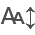

check


['110']-Height  ['110']-Height_Err  ['110']-PeakCentre  \
GroupNo                                                           
1.0           58.286821            3.108940            2.120836   
2.0           39.051899            2.841822            2.120752   
3.0           18.830733            2.048757            2.119947   
4.0           48.232857            3.108819            2.121132   
5.0           35.358723            2.675562            2.120985   
6.0           25.031600            2.589446            2.120433   
7.0           28.571716            2.536954            2.120318   
8.0           22.027500            2.115397            2.121327   
9.0           20.800147            2.318788            2.120538   
10.0          22.124569            1.952697            2.121132   
11.0          14.277233            1.708499            2.121445   
12.0          14.462839            2.199666            2.120335   
13.0          12.537988            1.323502            2.121016   
14.0          12.812775            1.531678            2.120873   
15.0           3.481619            6.151055            2.036918   
16.0           5.501627            0.422097            2.122864   
17.0          12.624728            1.906177            2.115311   
18.0           8.481696            1.116135            2.116976   
19.0           2.157801            0.478779            2.119319   
20.0          11.485521            1.559388            2.116477   
21.0          13.391745            1.873771            2.116179   
22.0          11.481770            1.762852            2.116307   
23.0           5.381467            0.906760            2.119222   
24.0           3.985827            0.621024            2.111361   
25.0           2.304135            0.392062            2.123597   
26.0           4.761775            0.824573            2.116603   
27.0           2.489610            0.573548            2.114349   
28.0           3.680296            0.584038            2.120138   
29.0           5.081278            0.849703            2.120709   
30.0          10.321295            1.410166            2.118283   

         ['110']-PeakCentre_Err  ['110']-Sigma  ['110']-Sigma_Err  \
GroupNo                                                             
1.0                    0.000175       0.004220           0.000142   
2.0                    0.000191       0.003235           0.000143   
3.0                    0.000269       0.003102           0.000213   
4.0                    0.000175       0.003240           0.000124   
5.0                    0.000201       0.003320           0.000153   
6.0                    0.000209       0.002499           0.000158   
7.0                    0.000218       0.003115           0.000174   
8.0                    0.000259       0.003306           0.000198   
9.0                    0.000231       0.002570           0.000173   
10.0                   0.000267       0.003499           0.000173   
11.0                   0.000329       0.003614           0.000286   
12.0                   0.000262       0.002251           0.000231   
13.0                   0.000425       0.005202           0.000350   
14.0                   0.000353       0.003752           0.000279   
15.0                   0.119523       0.050574           0.037484   
16.0                   0.002081       0.026480           0.002680   
17.0                   0.000470       0.003315           0.000395   
18.0                   0.000477       0.006289           0.000401   
19.0                   0.001646       0.011223           0.001224   
20.0                   0.000403       0.004265           0.000368   
21.0                   0.000324       0.003919           0.000309   
22.0                   0.000326       0.002751           0.000282   
23.0                   0.000750       0.006904           0.000786   
24.0                   0.001223       0.007132           0.000929   
25.0                   0.001582       0.014459           0.001983   
2

In [19]:
init_notebook_mode(all_interactive=True)
options.maxBytes = 0

def PeakAcrossBanks(RunNo,peak_list=None,PixelGrouping=None,RebinParams='-0.0005',save=False):
    # Loading the original data
    filepath,_,sumSpec = fileSearch(run=RunNo,exp=None,bank=None,save=False)
    testX = mtd[sumSpec].dataX(0) #This value is needed to calibrate the CIF files in the Cubic Peak Fit
    #Loading the data and converting it to d-spacing
    DiffnDataWS = Load(Filename=filepath, OutputWorkspace='DiffnDataWS', SpectrumMax=2400)
    ConvertUnits(InputWorkspace='DiffnDataWS', OutputWorkspace='DiffnDataWS-dSp', Target='dSpacing', AlignBins=True)
    # Group pixels and d-spacing axis to appropriate bin sizes
    LoadDetectorsGroupingFile(InputFile=PixelGrouping, InputWorkspace='DiffnDataWS-dSp', OutputWorkspace='XML-SpatialGrouping')
    GroupDetectors(InputWorkspace='DiffnDataWS-dSp', OutputWorkspace='DiffnDataWS-dSp-grp', IgnoreGroupNumber=False, CopyGroupingFromWorkspace='XML-SpatialGrouping')
    Rebin(InputWorkspace='DiffnDataWS-dSp-grp', OutputWorkspace='DiffnDataWS-dSp-grp-reb', Params=RebinParams)
    # Fit peak(s) to all spectra in workspace
    NumSpectra = mtd['DiffnDataWS-dSp-grp-reb'].getNumberHistograms()
    SpectraRefString = ";".join([f'DiffnDataWS-dSp-grp-reb,sp{i+1}' for i in range(NumSpectra)])
    if peak_list == None:
        _, x, y, plot, paramsArr = cubicPeakFit(run=RunNo,exp=None,bank=None,size=len(testX),bg=False,peak_bg=True,save=False,local=False,path=None)
    else:
        #If the user provides a list of peaks, this function finds the rest of the data needed for the script
        _, x, y, plot, paramsArr = inputPeakFit(run=RunNo,exp=None,bank=None,x0=peak_list,cryst=None,size=len(testX),bg=False,peak_bg=True,save=False,local=False,path=None)
    x0 = []
    hkls = []
    widths = []
    for para in paramsArr:
        #This extracts the peak locations, hkls, and heights from the peak fit for later use
        x0.append(para[2])
        hkls.append(para[1])
        widths.append(para[4])
    peaklen = len(x0)
    dMin, dMax = np.amin(x), np.amax(x)
    FitResults=None # Merge
    for i in range(peaklen):
        PeakPosition = x0[i]
        PeakWidth = widths[i]
        #This is to make sure the peaks retrieved are found within the spectra being analysed
        if dMin < PeakPosition < dMax:
            PeakHeights=[]
            for j in range(NumSpectra):
                PeakHeights.append(mtd['DiffnDataWS-dSp-grp-reb'].dataY(j)[mtd['DiffnDataWS-dSp-grp-reb'].yIndexOfX(PeakPosition)])
            #This takes the Peak Height across all the spectra and averages it to a single value
            PeakHeight = np.mean(PeakHeights)
            PeakFitString = f"name=Gaussian,Height={PeakHeight},PeakCentre={PeakPosition},Sigma={PeakWidth}"
            #This plots the peaks again by spectra
            PlotPeakByLogValue(Input=SpectraRefString, OutputWorkspace='DiffnDataWS-dSp-grp-reb-Fit', Function=PeakFitString, FitType='Individual', 
                               StartX=PeakPosition*0.98, EndX=PeakPosition*1.02)
            # Convert results from mantid TableWorkspace to Pandas
            ResultsDict = mtd['DiffnDataWS-dSp-grp-reb-Fit'].toDict()
            ResultsDict['GroupNo'] = ResultsDict.pop('axis-1')
            # Rename column headings to include peak name
            for ColumnName in ['Height', 'Height_Err', 'PeakCentre', 'PeakCentre_Err', 'Sigma', 'Sigma_Err', 'Integrated Intensity', 'Integrated Intensity_Err', 'Chi_squared']:
                ResultsDict[f'{hkls[i]}-{ColumnName}'] = ResultsDict.pop(ColumnName)
            ResultsDF = pd.DataFrame.from_dict(ResultsDict).set_index("GroupNo")
            
            if FitResults is not None:
                FitResults = pd.merge(FitResults, ResultsDF, on="GroupNo")
            else:
                FitResults = ResultsDF
    dfHDF = FitResults
    dfHDF.reset_index(drop=True)

    name = f'{RunNo}_Grp_HDF'
    try:
        #This stores the resulting pandas as a HDF file. On ocassion, this would cause issue for various unknown reasons, hence the error throw
        storeGrpPeaks(name, FitResults, peaklen,hkls)
    except ValueError:
        print('Unable to store as HDF.')
        pass

    #This retrieves other data useful for Neutron Diffraction data analysis from each spectra then appends it to the pandas
    Azimuths = [np.rad2deg(mtd['DiffnDataWS-dSp-grp-reb'].spectrumInfo().azimuthal(i)) for i in range(NumSpectra)]
    TwoThetas = [np.rad2deg(mtd['DiffnDataWS-dSp-grp-reb'].spectrumInfo().signedTwoTheta(i)) for i in range(NumSpectra)]
    FitResults['Azimuth']=Azimuths
    FitResults['TwoTheta']=TwoThetas
    for PixelGroup in FitResults.index:
        if -90 < FitResults.loc[PixelGroup, "Azimuth"] < 90:   # Indicates north bank
            FitResults.loc[PixelGroup, "TwoTheta"] = abs(FitResults.loc[PixelGroup, "TwoTheta"])
        if FitResults.loc[PixelGroup, "Azimuth"] < -90:        # -163 or -171.5, corresponds to -17 or -8.5
            FitResults.loc[PixelGroup, "Azimuth"] = -180 - FitResults.loc[PixelGroup, "Azimuth"]
            FitResults.loc[PixelGroup, "TwoTheta"] = -1 * abs(FitResults.loc[PixelGroup, "TwoTheta"])
        if FitResults.loc[PixelGroup, "Azimuth"] > 90:        # 163 or 171.5, corresponds to 17 or 8.5
            FitResults.loc[PixelGroup, "Azimuth"] = 180 - FitResults.loc[PixelGroup, "Azimuth"]
            FitResults.loc[PixelGroup, "TwoTheta"] = -1 * abs(FitResults.loc[PixelGroup, "TwoTheta"])
        if abs(FitResults.loc[PixelGroup, "TwoTheta"]) < 10:  # Degenerate case gives erroneous values - form of gimbal lock?
            FitResults.loc[PixelGroup, "Azimuth"] = 0
            FitResults.loc[PixelGroup, "TwoTheta"] = -90
            
    return FitResults, name

#This is selecting the xml grouping file to use in this case
GroupingFile = os.path.join(GroupingFiles, 'ENGINX_Texture30_grouping.xml')

df, nm =PeakAcrossBanks(351469, peak_list=None, PixelGrouping=GroupingFile, RebinParams=-0.0005,save=False)
df

After using the Peak Across Banks function to retrieve the peaks and information about them from the data, this function correlates said peaks against each other, using this to determine the possibility of twinning.

check


Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


check


Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


check


Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


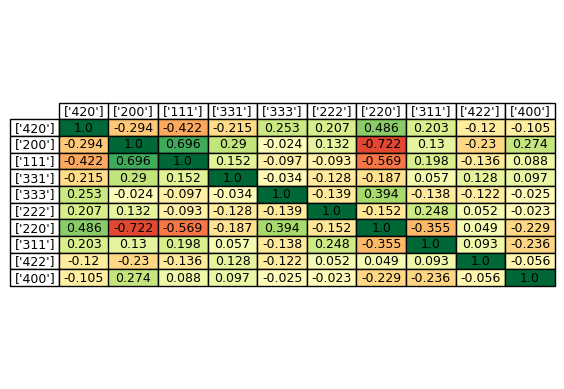

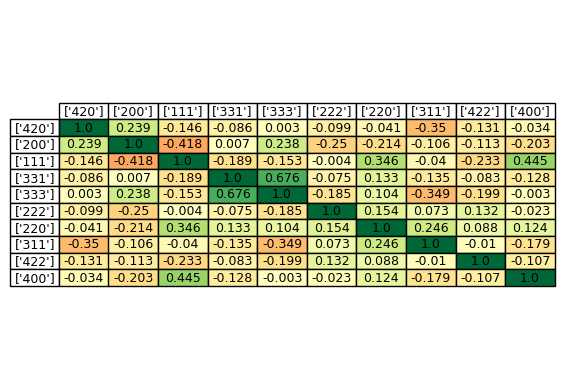

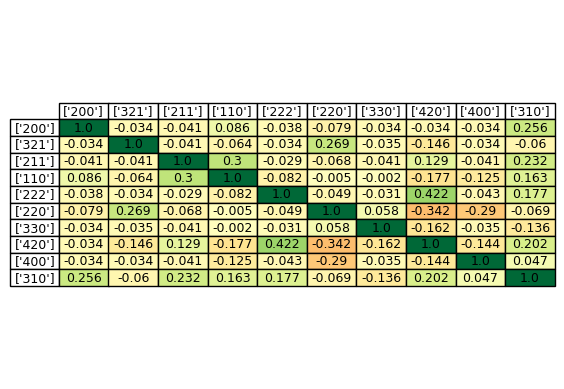

In [38]:
def AnalyseOrientationRelations(FitResDF,name,corr="Pearson"):
    #This is to determine a location to save the correlation table
    currdir = os.getcwd()
    savedir = os.path.join(currdir, "Saves")
    figName = f'{name}_Orientation_{corr}_Correlation.png'
    filedir = os.path.join(savedir, str(name))
    figdir = os.path.join(filedir, figName)
    #This retrieves the peaks
    Peaks = list({ColNamePart[0] for ColNamePart in df.columns.str.split("-") if len(ColNamePart) == 2})
    NumPeaks = len(Peaks)
    #This creates a matrix in order to store the correlation values
    Correlations = np.zeros((NumPeaks, NumPeaks)) 
    for PeakInd1 in range(NumPeaks):
        for PeakInd2 in range(NumPeaks):
            #I found a few different useful correlation functions, so I added the option to select them here
            if corr == "Pearson":
                #The scipy and numpy pearson coefficient values are interchangable, but the scipy one is easier to extract so I used it here
                Correlations[PeakInd1,PeakInd2] = ss.pearsonr(FitResDF[f'{Peaks[PeakInd1]}-Integrated Intensity'],FitResDF[f'{Peaks[PeakInd2]}-Integrated Intensity'])[0]
            elif corr == "Spearman":
                Correlations[PeakInd1,PeakInd2] = ss.spearmanr(FitResDF[f'{Peaks[PeakInd1]}-Integrated Intensity'],FitResDF[f'{Peaks[PeakInd2]}-Integrated Intensity'])[0]
            elif corr == "Kendall":
                Correlations[PeakInd1,PeakInd2] = ss.kendalltau(FitResDF[f'{Peaks[PeakInd1]}-Integrated Intensity'],FitResDF[f'{Peaks[PeakInd2]}-Integrated Intensity'])[0]
            elif corr == "Regression":
                Correlations[PeakInd1,PeakInd2] = ss.linregress(FitResDF[f'{Peaks[PeakInd1]}-Integrated Intensity'],FitResDF[f'{Peaks[PeakInd2]}-Integrated Intensity']).rvalue
            elif corr == "Xi":
                #Need to update to current version of scipy for this correlation to work. Recent coefficient for correlation which works in many more cases than other correlation functions tend to 
                #https://souravchatterjee.su.domains/beam-correlation-trans.pdf
                Correlations[PeakInd1,PeakInd2] = ss.chatterjeexi(FitResDF[f'{Peaks[PeakInd1]}-Integrated Intensity'],FitResDF[f'{Peaks[PeakInd2]}-Integrated Intensity'],nan_policy='propagate')[0]
            elif corr == "Weighted Kendall":
                Correlations[PeakInd1,PeakInd2] = ss.weightedtau(FitResDF[f'{Peaks[PeakInd1]}-Integrated Intensity'],FitResDF[f'{Peaks[PeakInd2]}-Integrated Intensity'])[0]
            else:
                #Failsafe if the user doesn't choose. Assume they want a Pearson as the code was originally written with this correlation in mind
                Correlations[PeakInd1,PeakInd2] = ss.pearsonr(FitResDF[f'{Peaks[PeakInd1]}-Integrated Intensity'],FitResDF[f'{Peaks[PeakInd2]}-Integrated Intensity'])[0]
    fig, axes = plt.subplots(1,1)
    axes.axis('off')
    CorrelationsNormalised = (Correlations + 1) / 2.
    #This colour codes the values
    CellColours = plt.cm.RdYlGn(CorrelationsNormalised)
    #This creates the table
    CorrTable = plt.table(cellText=Correlations.round(decimals=3), cellColours=CellColours, loc='center', cellLoc='center',colLabels=Peaks, rowLabels=Peaks)
    CorrTable.set_fontsize(20)
    sortedCorr = sortCorrelations(Correlations,Peaks,NumPeaks)
    saveOrientation(name,corr,Correlations,NumPeaks,sortedCorr,Peaks)
    plt.savefig(figdir)

#This function takes the correlations and sorts the peaks by which correlates most to which, e.g. [1,1,1] is ranked no. 1 for [2,0,0] etc.
def sortCorrelations(Correlations,peaks,peaklen):
    sortedDic = {}
    i = 0
    for peak in peaks:
        peakCorr = []
        orderedPeaks = []
        for j in range(peaklen):
            #This collects the correlations for a specific peak
            peakCorr.append(Correlations[i,j])
        #Then sorts it highest to lowest
        peakCorrSorted = np.sort(peakCorr)
        peakCorrSorted = np.flip(peakCorrSorted)
        for sortedPeak in peakCorrSorted:
            #And assigns a peak to each correlation
            orderedPeaks.append(peaks[int(np.argwhere(peakCorr == sortedPeak))])
        sortedDic[f'{peak}_ordered'] = orderedPeaks
        i = i + 1
    return sortedDic

#peak_list = [1.2738479957417232, 1.2738479957417232, 1.0851454279645192, 1.0381322738799574, 0.8990426659430917, 0.8255981533409046, 0.8255981533409046,
#         0.7348216023665199, 0.691924807395331, 0.6089476736884353, 0.6089476736884353, 0.5690839854323809, 0.5478522384264389, 0.5047387929755975, 0.5047387929755975]
#df,nm = PeakAcrossBanks(216884, peak_list=peak_list, PixelGrouping=GroupingFile, RebinParams=-0.0001)
#AnalyseOrientationRelations(df,nm,corr="Pearson")
#df,nm = PeakAcrossBanks(216885, peak_list=peak_list, PixelGrouping=GroupingFile, RebinParams=-0.0001)
#AnalyseOrientationRelations(df,nm,corr="Pearson")
#df,nm = PeakAcrossBanks(216886, peak_list=peak_list, PixelGrouping=GroupingFile, RebinParams=-0.0001)
#AnalyseOrientationRelations(df,nm,corr="Pearson")

df,nm = PeakAcrossBanks(351364, PixelGrouping=GroupingFile, RebinParams=-0.0001)
AnalyseOrientationRelations(df,nm,corr="Pearson")
df,nm = PeakAcrossBanks(351464, PixelGrouping=GroupingFile, RebinParams=-0.0001)
AnalyseOrientationRelations(df,nm,corr="Pearson")
df,nm = PeakAcrossBanks(351538, PixelGrouping=GroupingFile, RebinParams=-0.0001)
AnalyseOrientationRelations(df,nm,corr="Pearson")

#WCu_list = [0.6202667890091988, 0.6202667890091988, 0.6202667890091988, 0.6740667707550556, 0.6740667707550556, 0.6933329804343151, 0.6951505473851887,
#            0.6951505473851887, 0.7373181006454548, 0.7373181006454548, 0.7373181006454548, 0.7373181006454548, 0.7373181006454548, 0.7373181006454548,
#            0.8289234749694812, 0.8289234749694812, 0.8289234749694812, 0.8289234749694812, 0.9034437199552963, 0.9034437199552963, 1.0437598885627335,
#            1.0895625757247467, 1.0895625757247467, 1.0895625757247467, 1.2774989984450706, 1.2774989984450706, 1.5813961926311264, 1.8060474677590959,
#            2.0844987246329736, 2.2357202949457444]
#df,nm = PeakAcrossBanks(352722, peak_list=WCu_list, PixelGrouping=GroupingFile, RebinParams=-0.0001)
#AnalyseOrientationRelations(df,nm,corr="Pearson")

The larger a grain, the more of a range you will see between the spectra that picks it up the most and that which picks up on it the least, and vice versa with a smaller grain. This intends to represent that, taking the intensities from each spectra, and ordering them by value regardless of bank or location. We should then be able to see the pattern mentioned earlier.

['420']    ['200']    ['111']    ['331']    ['333']    ['222']  \
351464   3.045118  20.724709  18.603139   9.648868  11.310269  12.759443   
351465  24.232208  21.876534  18.496408   9.374291  10.918884  12.212465   
351466  17.537633  28.869530  18.554226  10.519492   9.317156  10.354461   
351467   8.126614  12.375804   0.000000   0.000000   0.000000  10.317149   
351468  10.766644   7.483780   0.000000   0.000000   0.000000   7.456954   
351469  11.105136   0.763505   0.000000   0.000000   0.000000  12.976008   

          ['220']    ['311']    ['422']    ['400']    ['321']   ['211']  \
351464  34.290939  38.355402  23.874783  16.451826   0.000000  0.000000   
351465  29.713890  23.655273  16.382976  10.443455   0.000000  0.000000   
351466  30.511642  28.703673   8.630278  10.768093   0.000000  0.000000   
351467  27.168418   0.000000   0.000000  14.968374  11.034392  8.497256   
351468  20.583923   0.000000   0.000000   6.808617  14.491213  8.950586   
351469   8.901769   0.000000   0.000000   5.923160   9.045606  6.827588   

          ['110']   ['330']   ['310']  
351464   0.000000  0.000000  0.000000  
351465   0.000000  0.000000  0.000000  
351466   0.000000  0.000000  0.000000  
351467  11.516515  1.964561  9.437476  
351468   2.726641  1.386647  3.926157  
351469  11.310874  7.864943  6.569402

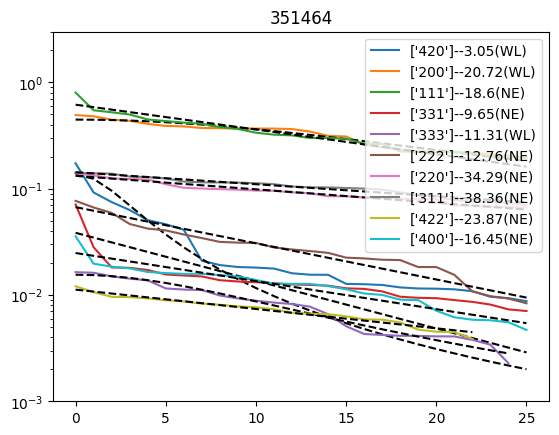

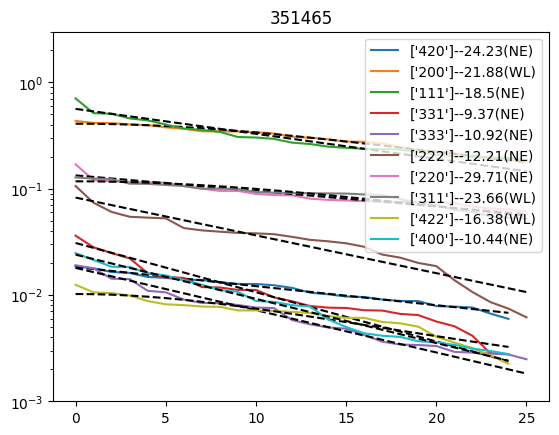

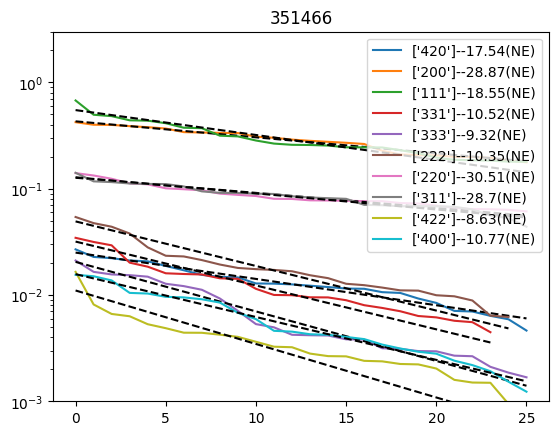

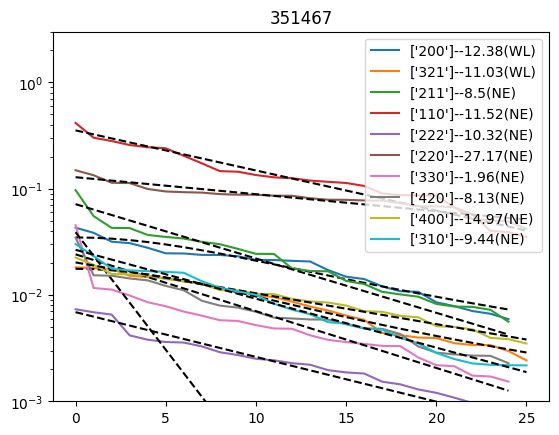

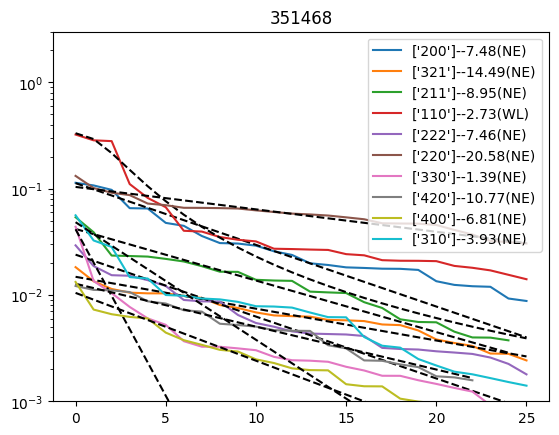

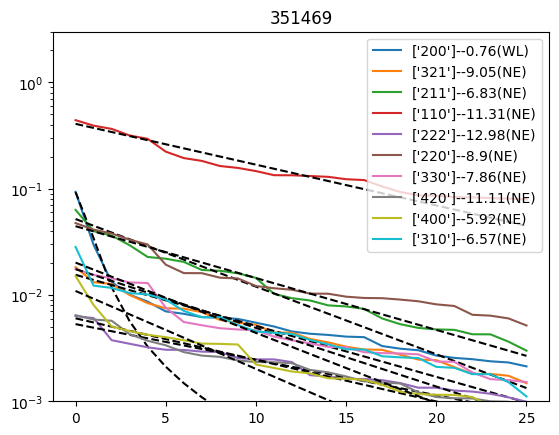

In [40]:
def AnalyseGrainSize(FitResDF, name, title=""):
    #This again retrieves the peaks from the pandas
    Peaks = list({ColNamePart[0] for ColNamePart in df.columns.str.split("-") if len(ColNamePart) == 2})
    fig, axes = plt.subplots(1,1)
    #This dictionary stores the Grain Size information to be used later
    Sizes = {}
    for peak in Peaks:
        IntensitySeries = f'{peak}-Integrated Intensity'
        #This retrieves the Integrated Intensity of each peak
        FitResDF[IntensitySeries] = FitResDF[IntensitySeries].mask(~FitResDF[IntensitySeries].between(1e-4,1e+4))
    #Determining a location to save the Grain Size Graphs
    currdir = os.getcwd()
    savedir = os.path.join(currdir, "Saves")
    figName = f'{title}_GrainSize_graph.png'
    filedir = os.path.join(savedir, str(name))
    figdir = os.path.join(filedir, figName)
    for peak in Peaks:
        #Retrieves all the Integrated Intensity values for a specific peak across the spectra, sorts it by size, then logs the y axis for the plot
        Intensities = FitResDF[f'{peak}-Integrated Intensity'].dropna().to_numpy()
        Intensities.sort()
        Intensities = Intensities[-2:2:-1]
        IntensityIndexes = np.array(range(len(Intensities)))
        plt.yscale('log')
        plt.ylim(1e-3, 3)
        plt.title(f'{title}')
        if len(Intensities) >= 2:
            #a_const = 10
            a_const = 5
            grain_param = 1
            #This performs a fit on the Grain Size graph with each function
            pfitNE = lm.create_params(a_psi = a_const, psi = grain_param)
            miniNE = lm.Minimizer(residualNE, pfitNE, fcn_args=(IntensityIndexes,Intensities),nan_policy='propagate')
            outNE = miniNE.leastsq()
            pfitCP = lm.create_params(a_alpha = a_const, alpha = grain_param)
            miniCP = lm.Minimizer(residualCP, pfitCP, fcn_args=(IntensityIndexes,Intensities),nan_policy='propagate')
            outCP = miniCP.leastsq()
            pfitWL = lm.create_params(a_w = a_const, w = grain_param)
            miniWL = lm.Minimizer(residualWL, pfitWL, fcn_args=(IntensityIndexes,Intensities),nan_policy='propagate')
            outWL = miniWL.leastsq()
            nameComp = ["NE","CP","WL"]
            #Then determines the closest fit
            fitComp = [abs(np.sum(outNE.residual)), abs(np.sum(outCP.residual)), abs(np.sum(outWL.residual))]
            bestOC = np.amin(fitComp)
            fit = nameComp[np.amin(np.argwhere(fitComp == bestOC))]
            if fit == "NE":
                best_fit = Intensities + outNE.residual
                psiFin = outNE.params['psi'].value
                plt.plot(Intensities, label=f'{peak}--{round(psiFin,2)}({fit})')
                plt.plot(best_fit, color='black', linestyle='dashed')
                plt.legend()
                Sizes[f'{peak}'] = outNE.params['psi'].value # Second parameter is gradient-like parameter that relates to the sizes. This is what is used to analyse the grain size.
                #The larger the gradient, the larger the grain size, and vice versa
            elif fit == "CP":
                aFin = outCP.params['alpha'].value
                best_fit = Intensities + outCP.residual
                plt.plot(Intensities, label=f'{peak}--{round(aFin,2)}({fit})')
                plt.plot(best_fit, color='black', linestyle='dashed')
                plt.legend()
                Sizes[f'{peak}'] = outCP.params['alpha'].value
            elif fit == "WL":
                wFin = outWL.params['w'].value
                best_fit = Intensities + outWL.residual
                plt.plot(Intensities, label=f'{peak}--{round(wFin,2)}({fit})')
                plt.plot(best_fit, color='black', linestyle='dashed')
                plt.legend()
                Sizes[f'{peak}'] = outWL.params['w'].value
        else:
            Sizes[f'{peak}'] = None
    plt.savefig(figdir)
    return Sizes

#These are the functions used for the fit and their respective residual functions
def NegativeExp(x, a_psi, psi):
    return a_psi*np.exp(-(x/psi))
#This minimises the residual to return the best fit
def residualNE(pars,x,data):
    model = NegativeExp(x, a_psi=pars['a_psi'],psi=pars['psi']) 
    return model - data
    
def ConstPower(x, a_alpha, alpha):
    return a_alpha*(x**(int(alpha)))
def residualCP(pars,x,data):
    model = ConstPower(x, a_alpha=pars['a_alpha'],alpha=pars['alpha']) 
    return model - data

def WLorentz(x, a_w, w):
    return a_w*(w**2/(w**2+x**2))
def residualWL(pars,x,data):
    model = WLorentz(x, a_w=pars['a_w'],w=pars['w']) 
    return model - data

#This runs the Grain Size Analysis on a range of runs
#For some reason, running this as a function proved difficult, so in the interest of time,
#this is purely an appended script
GroupingFile = os.path.join(GroupingFiles,'ENGINX_Texture30_grouping.xml')
UniquePointRange = list(range(351464,351470))
#This is to store a pandas of the grainsize information across multiple runs
sizes = []
for RunNo in UniquePointRange:
    df,nm = PeakAcrossBanks(RunNo, PixelGrouping=GroupingFile, RebinParams=-0.0005)
    grainsize = AnalyseGrainSize(df, nm, title=RunNo)
    grainsizedf = pd.DataFrame(grainsize, index=[RunNo])
    sizes.append(grainsizedf)

SizeDF = pd.concat(sizes)
#This is to remove any NaNs in the datafile for later use 
SizeDF = SizeDF.fillna(0)
SizeDF

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


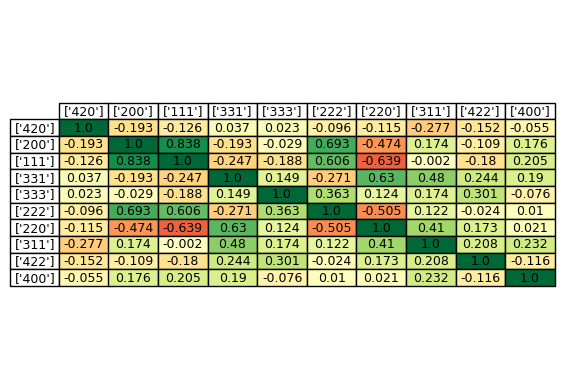

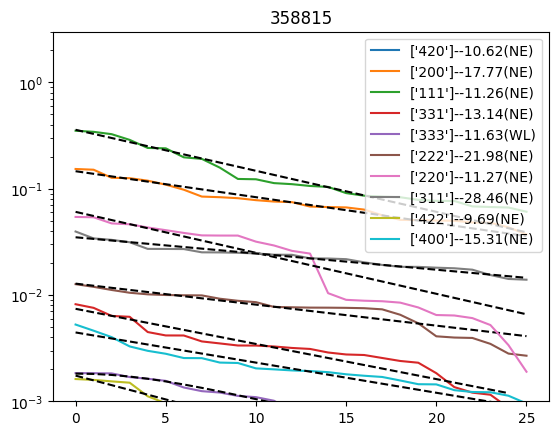

In [53]:
GroupingFile = os.path.join(GroupingFiles, 'ENGINX_Texture30_grouping.xml')

RunNo = 358815
df, nm =PeakAcrossBanks(RunNo, peak_list=None, PixelGrouping=GroupingFile, RebinParams=-0.0005,save=False)
AnalyseOrientationRelations(df,nm,corr="Pearson")
grainsize = AnalyseGrainSize(df, nm, title=RunNo)